# Read checkerboard model and plot velocity and azimuthal anisotropy in horizontal section

In [1]:
from pytomoatt.model import ATTModel
import numpy as np
# initial model hdf5 file
init_model_file = '2_models/model_init_N7_201_201.h5'
# checkerboard model hdf5 file
ckb_model_file = '2_models/model_ckb_N7_201_201.h5'
# input parameters file
par_file = '3_input_params/input_params_inv.yaml'

# read model file by pytomoatt
model = ATTModel.read(init_model_file, par_file)
init_model = model.to_xarray()

model = ATTModel.read(ckb_model_file, par_file)
ckb_model = model.to_xarray()



# we can access the velocity at arbitrary depth
depth = 0.0
tmp = ckb_model.interp_dep(depth, field='vel')
lon = tmp[:,0]
lat = tmp[:,1]
vel_ckb = tmp[:,2]
vel_init = init_model.interp_dep(depth, field='vel')[:,2]
vel_pert = (vel_ckb - vel_init)/vel_init * 100.0

# similarly, anisotropic parameters xi and eta
xi_ckb  = ckb_model.interp_dep(depth, field='xi')[:,2]
eta_ckb = ckb_model.interp_dep(depth, field='eta')[:,2]

# magnitude and direction of anisotropy
tmp     = ckb_model.interp_dep(depth, field='phi', samp_interval=20) # fast velocity direction, samp_interval is the sampling one point every 20 points in each axis
ani_lon = tmp[:,0]
ani_lat = tmp[:,1]
ani_phi = tmp[:,2]
ani_epsilon = ckb_model.interp_dep(depth, field='epsilon', samp_interval=20)[:,2]

epsilon = ckb_model.interp_dep(depth, field='epsilon')[:,2]

# Pygmt plot velocity perturbation related to initial model, xi, eta, fast velocity directions

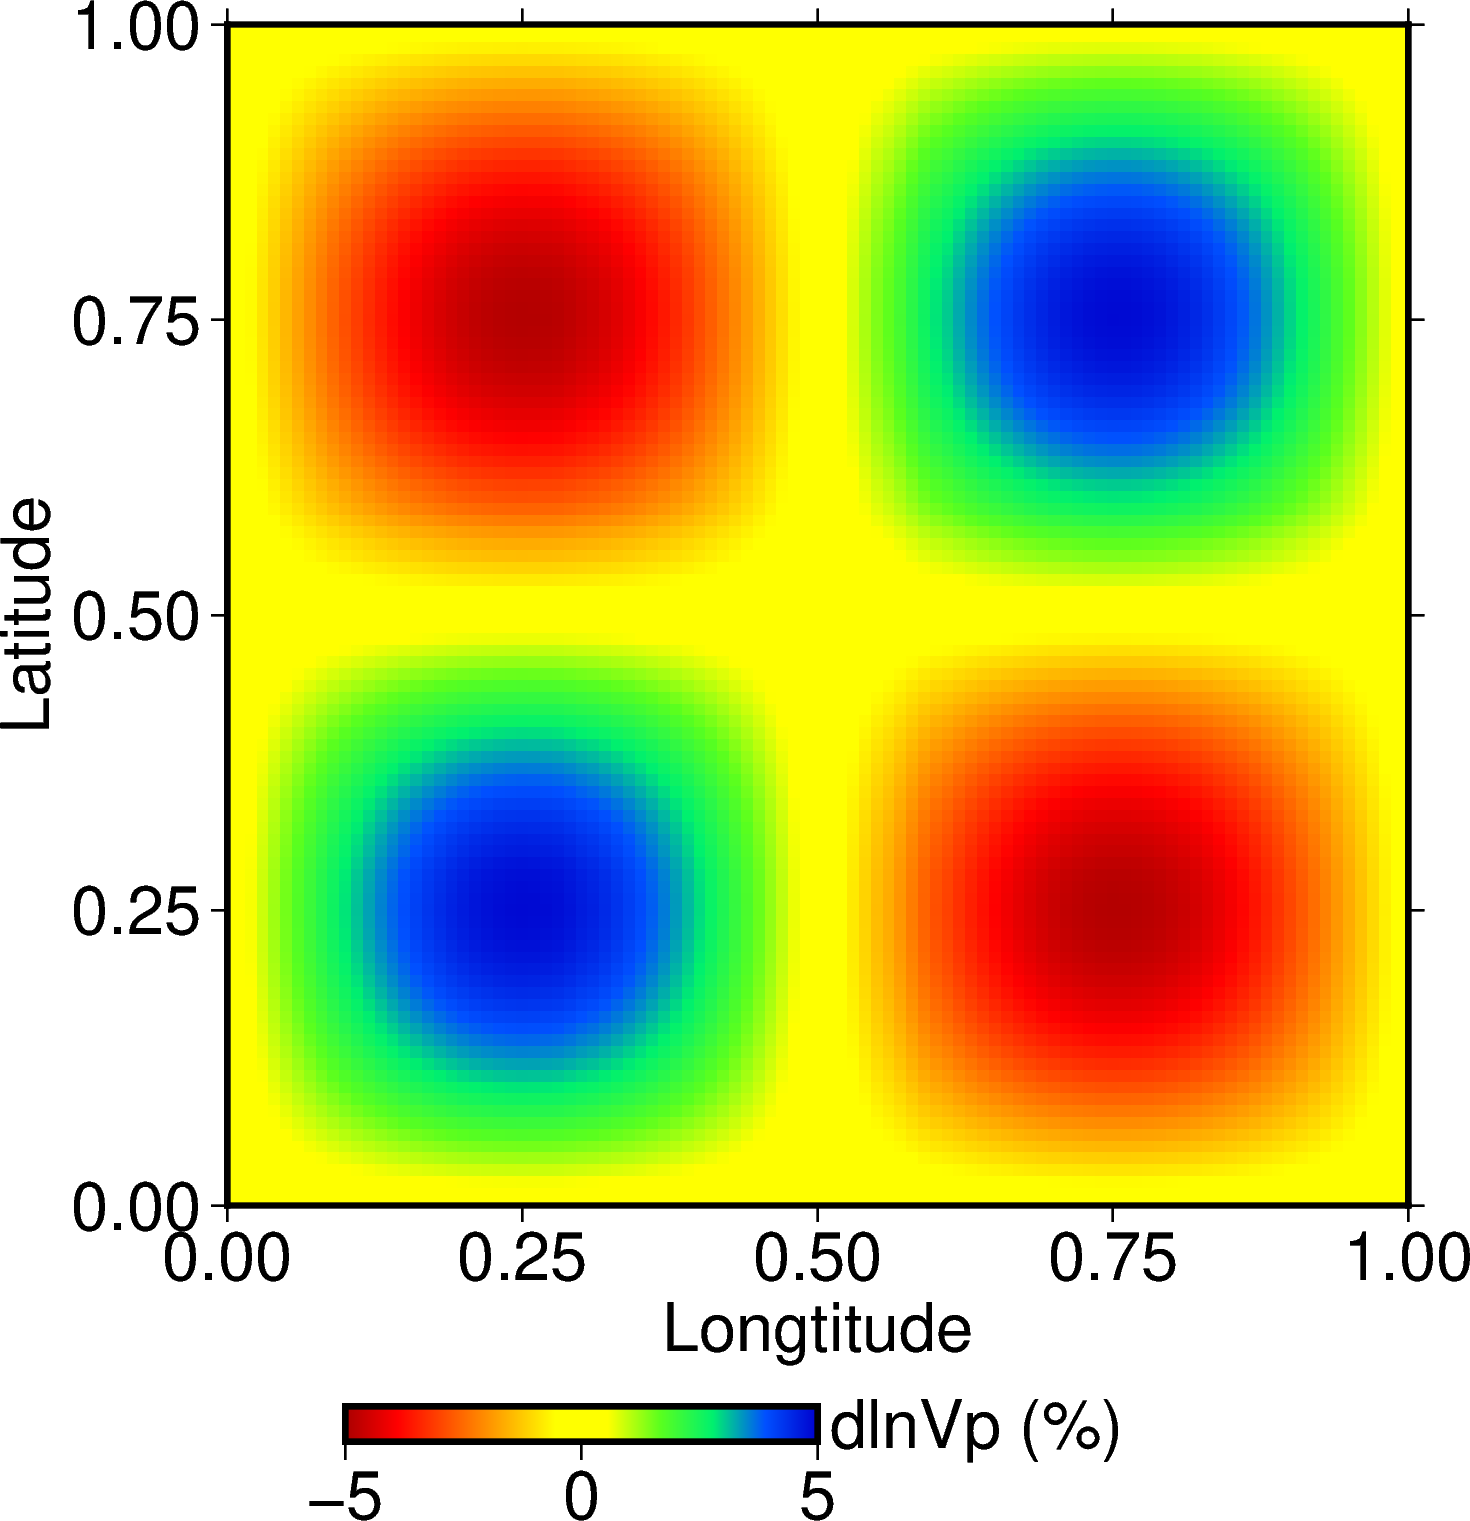

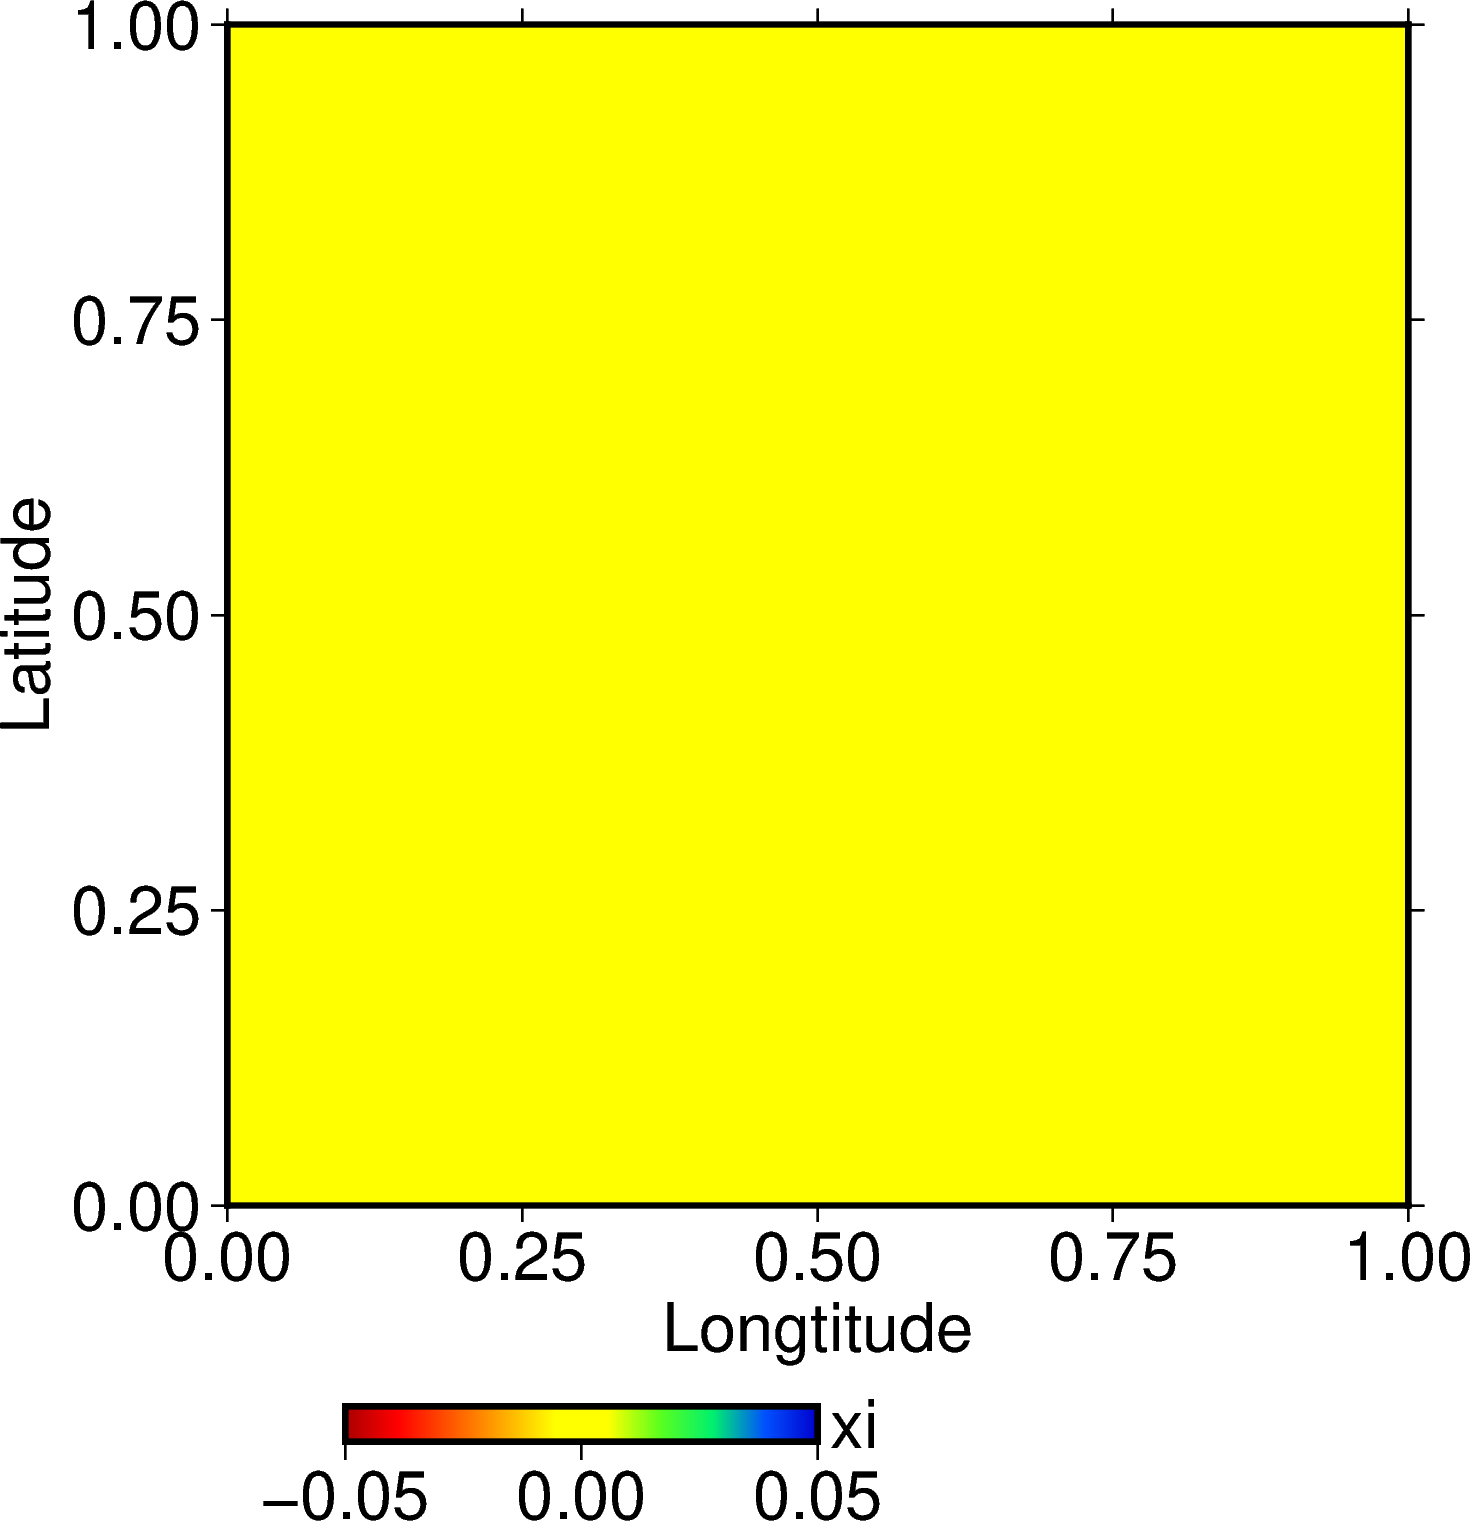

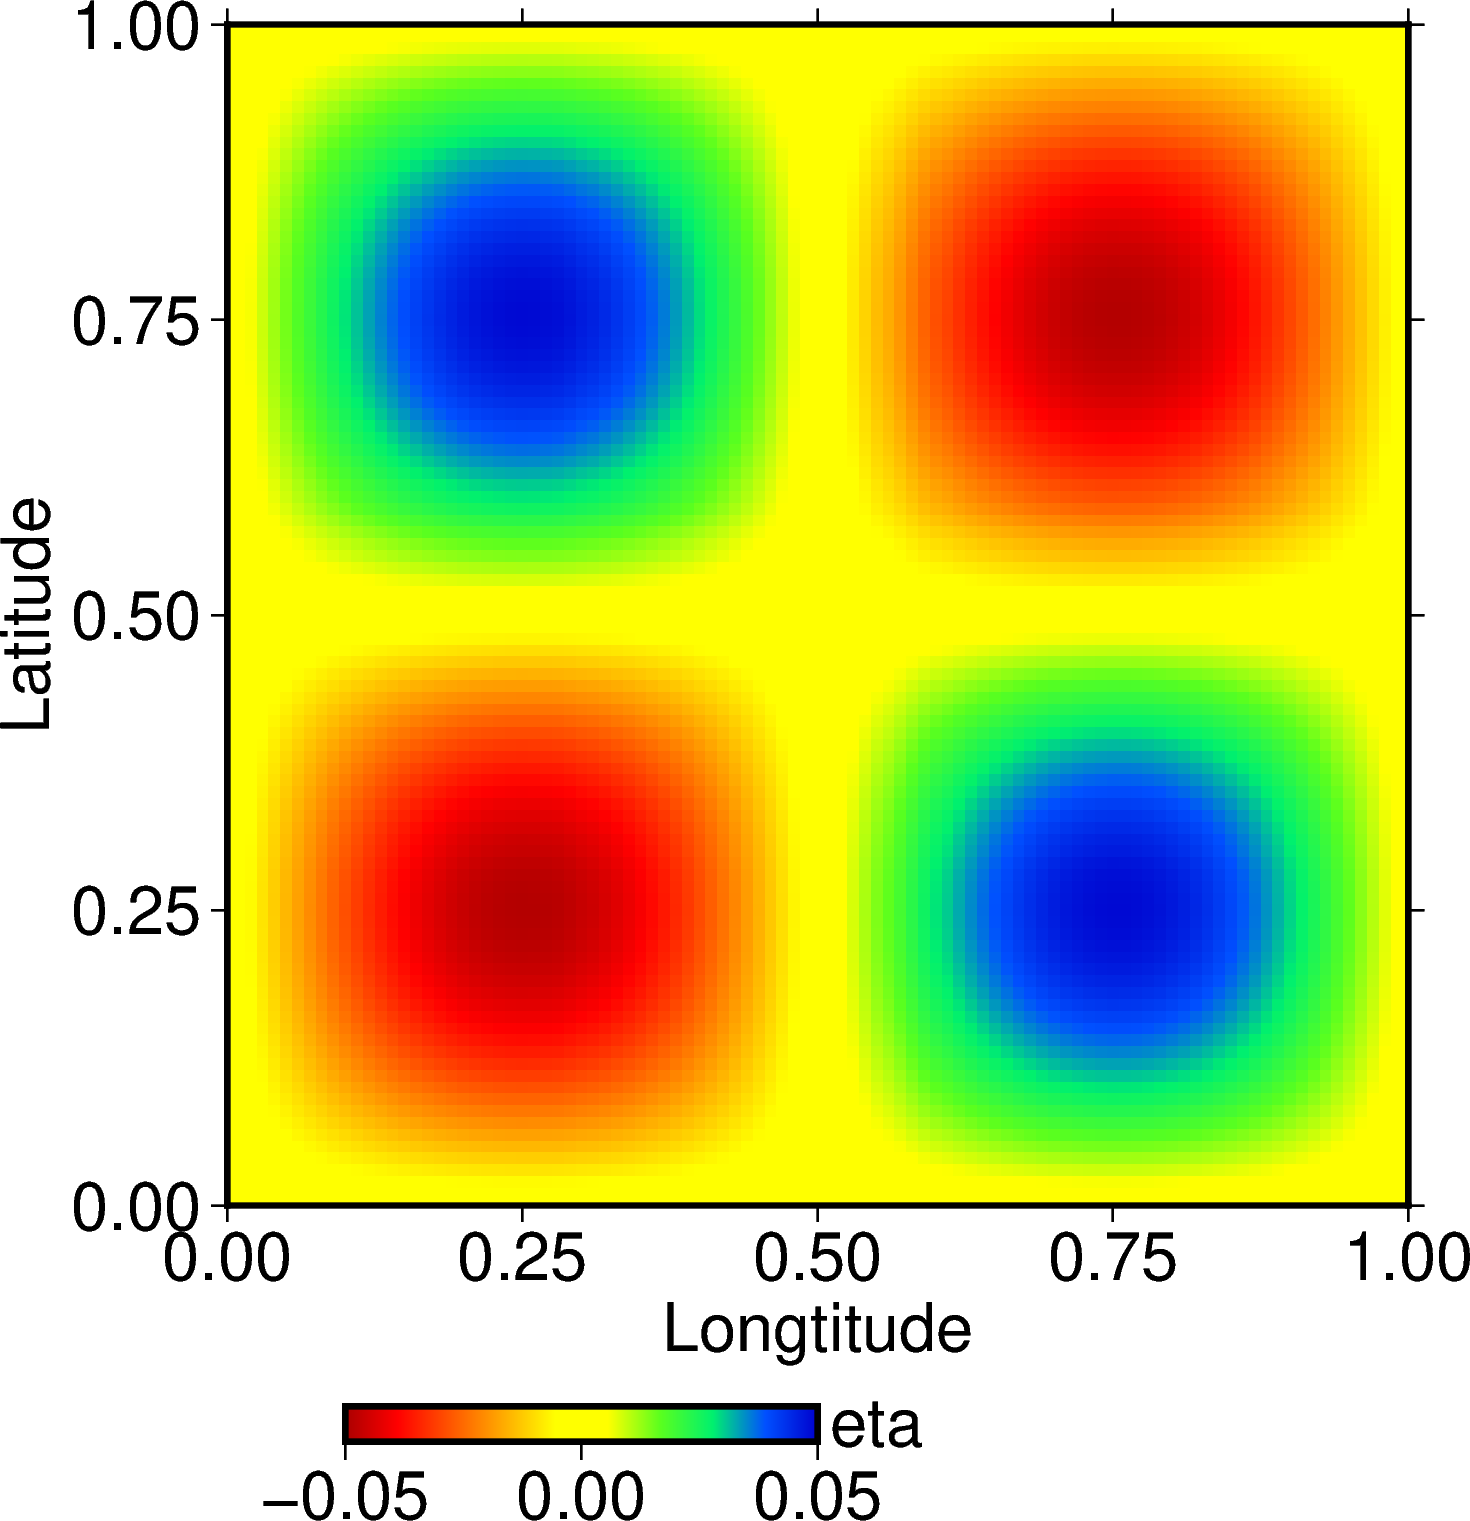

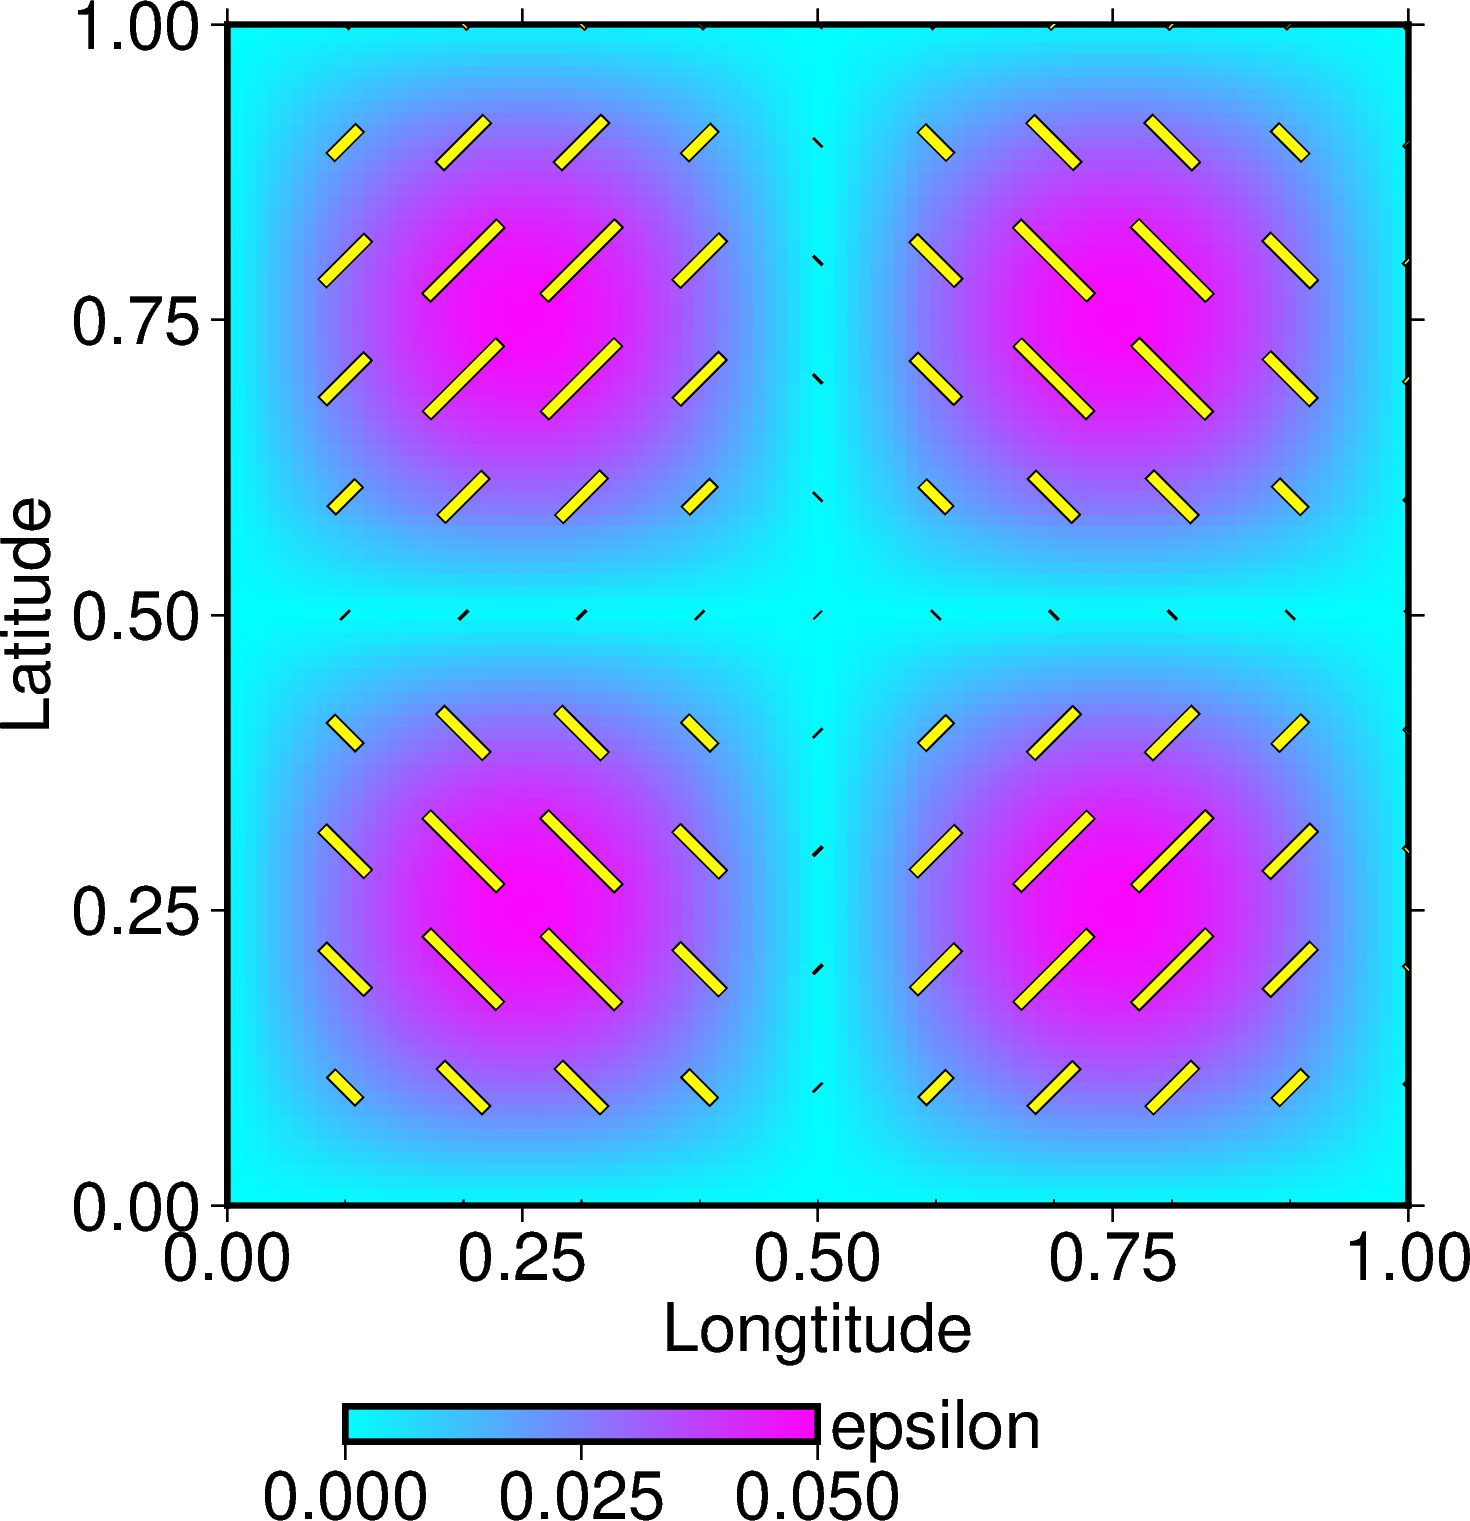

In [2]:
import sys
sys.path.append('../utils')
from functions_for_plot import plot_map

dx = 0.01; dy = 0.01

fname = 'img/2a_ckb_vel_pert.png'
fig = plot_map(lon,lat,vel_pert,dx,dy,
            fname = fname, 
            axis_label = ["Longtitude","Latitude"],
            colorbar = "dlnVp (%)",
            cpt_range = [-5,5],)

fname = 'img/2b_ckb_xi.png'
fig = plot_map(lon,lat,xi_ckb,dx,dy,
            fname = fname, 
            axis_label = ["Longtitude","Latitude"],
            colorbar = "xi",
            cpt_range = [-0.05,0.05],)

fname = 'img/2c_ckb_eta.png'
fig = plot_map(lon,lat,eta_ckb,dx,dy,
            fname = fname, 
            axis_label = ["Longtitude","Latitude"],
            colorbar = "eta",
            cpt_range = [-0.05,0.05],)

fname = 'img/2d_ckb_ani.png'
ani = np.hstack([ani_lon[:,None], ani_lat[:,None], ani_phi[:,None], ani_epsilon[:,None]*20, np.ones((ani_phi.shape[0],1))*0.1])
fig = plot_map(lon,lat,epsilon,dx,dy,
            anisotropy = ani,
            fname = fname, 
            axis_label = ["Longtitude","Latitude"],
            colorbar = "epsilon",
            cmap = "cool",
            cpt_range = [0,0.05],)